In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext lab_black
%matplotlib inline

In [2]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12560828584358284416
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4937233203
locality {
  bus_id: 1
  links {
  }
}
incarnation: 440309693219896134
physical_device_desc: "device: 0, name: GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
import tensorflow as tf

tf.debugging.set_log_device_placement(True)

# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [4]:
import numpy as np
import scipy as scipy
import os
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from tensorflow.keras.layers import GaussianNoise
from helpers import *
import cv2

In [5]:
# Import all the necessary for our model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.regularizers import l2

# from tensorflow.keras.models import Sequential, load_model
# from tensorflow.keras.layers import (
#     Activation,
#     Dropout,
#     Flatten,
#     Dense,
#     Conv2D,
#     MaxPooling2D,
#     LeakyReLU,
# )
from tensorflow.compat.v2.keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

In [6]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [7]:
from keras_tqdm import TQDMNotebookCallback

# keras, model definition...
cb = TQDMNotebookCallback()
setattr(cb, "on_train_batch_begin", lambda x, y: None)
setattr(cb, "on_train_batch_end", lambda x, y: None)

# model.fit(X_train, Y_train, verbose=0, callbacks=[cb])

Using TensorFlow backend.


In [8]:
import numpy as np
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score


def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# Loading images

In [9]:
# Load a set of images
root_dir = "data/"

# Select the directory for the images and load them
image_dir_train = root_dir + "training/images/"
files = os.listdir(image_dir_train)
n_train = len(files)

print("Loading " + str(n_train) + " images")
imgs_train = np.asarray(
    [load_image(image_dir_train + files[i]) for i in range(n_train)]
)

# Select the directory for groundtruth images and load them
gt_dir_train = root_dir + "training/groundtruth/"
print("Loading " + str(n_train) + " groundtruth images")
gt_imgs_train = np.asarray(
    [load_image(gt_dir_train + files[i]) for i in range(n_train)]
)

Loading 100 images
Loading 100 groundtruth images


In [10]:
imgs_train.shape

(100, 400, 400, 3)

In [11]:
gt_imgs_train.shape

(100, 400, 400)

In [12]:
image_size = 400

# We separate the images from the groundtruth images
img_patches_train = [
    img_crop(imgs_train[i], image_size, image_size) for i in range(n_train)
]
gt_patches_train = [
    img_crop(gt_imgs_train[i], image_size, image_size) for i in range(n_train)
]

# Linearize the list and labeling them X and Y
X_train = np.asarray(
    [
        img_patches_train[i][j]
        for i in range(len(img_patches_train))
        for j in range(len(img_patches_train[i]))
    ]
)
Y_train = np.asarray(
    [
        gt_patches_train[i][j]
        for i in range(len(gt_patches_train))
        for j in range(len(gt_patches_train[i]))
    ]
)

In [13]:
X_train.shape

(100, 400, 400, 3)

In [14]:
Y_train.shape

(100, 400, 400)

In [ ]:
# Select the directory for the images and load them
image_dir_val = root_dir + "validating/images/"
files = os.listdir(image_dir_val)
n_val = len(files)

print("Loading " + str(n_val) + " images")
imgs_val = np.asarray([load_image(image_dir_val + files[i]) for i in range(n_val)])

# Select the directory for groundtruth images and load them
gt_dir_val = root_dir + "validating/groundtruth/"
print("Loading " + str(n_val) + " groundtruth images")
gt_imgs_val = np.asarray([load_image(gt_dir_val + files[i]) for i in range(n_val)])

In [ ]:
imgs_val.shape

In [ ]:
gt_imgs_val.shape

In [ ]:
image_size = 400

# We separate the images from the groundtruth images
img_patches_val = [img_crop(imgs_val[i], image_size, image_size) for i in range(n_val)]
gt_patches_val = [
    img_crop(gt_imgs_val[i], image_size, image_size) for i in range(n_val)
]

# Linearize the list and labeling them X and Y
X_val = np.asarray(
    [
        img_patches_val[i][j]
        for i in range(len(img_patches_val))
        for j in range(len(img_patches_val[i]))
    ]
)
Y_val = np.asarray(
    [
        gt_patches_val[i][j]
        for i in range(len(gt_patches_val))
        for j in range(len(gt_patches_val[i]))
    ]
)

In [ ]:
X_val.shape

In [ ]:
Y_val.shape

# Generating mini-batch and running data augmentation

In [ ]:
def create_minibatch(X, Y, n):

    # Fix the seed
    np.random.seed(1)

    # We define the window size of 72, batch size of 100 (empirically chosen)
    # and patch size should correspond to 16
    w_size = 72
    batch_size = 100
    patch_size = 16
    num_images = n

    while True:
        # Generate one minibatch
        batch_image = np.empty((batch_size, w_size, w_size, 3))
        batch_label = np.empty((batch_size, 2))

        for i in range(batch_size):

            # Select a random index represnting an image
            random_index = np.random.choice(num_images)

            # Width of original image
            width = 400

            # Sample a random window from the image
            random_sample = np.random.randint(w_size // 2, width - w_size // 2, 2)

            # Create a sub image of size 72x72
            sampled_image = X[random_index][
                random_sample[0] - w_size // 2 : random_sample[0] + w_size // 2,
                random_sample[1] - w_size // 2 : random_sample[1] + w_size // 2,
            ]

            # Take its corresponding ground-truth image
            correspond_ground_truth = Y[random_index][
                random_sample[0] - patch_size // 2 : random_sample[0] + patch_size // 2,
                random_sample[1] - patch_size // 2 : random_sample[1] + patch_size // 2,
            ]

            # We set in the label depending on the threshold of 0.2
            # The label becomes either 0 or 1 by applying to_categorical with parameter 2
            label = to_categorical(
                (np.array([np.mean(correspond_ground_truth)]) > 0.2) * 1, 2
            )

            # The image augmentation is based on both flipping and rotating (randomly in steps of 45°)
            # Random vertical and horizontal flip
            if np.random.choice(2) == 1:
                sampled_image = np.flipud(sampled_image)

            if np.random.choice(2) == 1:
                sampled_image = np.fliplr(sampled_image)

            # Random rotation in steps of 45°
            rotations = [0, 45, 90, 135, 180, 225, 270, 315]

            # We select a rotation degree randomly
            rotation_choice = np.random.choice(len(rotations))

            # Rotate it using the random value (uses the scipy library)
            sampled_image = scipy.ndimage.rotate(
                sampled_image,
                rotations[rotation_choice],
                order=1,
                reshape=False,
                mode="reflect",
            )

            # We put in the sub image and its corresponding label before yielding it
            batch_image[i] = sampled_image
            batch_label[i] = label

        # Yield the mini_batch to the model
        yield (batch_image, batch_label)

# Model 1

In [ ]:
class cnn_model:

    # Initialize the class
    def __init__(self, shape, batch_normalization, activation):
        self.shape = shape
        self.batch_normalization = batch_normalization
        self.activation = activation
        self.model = self.initialize_cnn_model(shape, batch_normalization, activation)

    def initialize_cnn_model(self, shape, batch_normalization, activation):
        #         print(activation)

        # INPUT
        # shape     - Size of the input images
        # OUTPUT
        # model    - Compiled CNN

        # Define hyperparamters
        KERNEL3 = (3, 3)
        KERNEL5 = (5, 5)

        # Define a model
        model = Sequential()

        # Add the layers
        # Selection of the model is described in the report
        # We use padding = 'same' to avoid issues with the matrix sizes
        model.add(Conv2D(64, KERNEL3, input_shape=shape, padding="same"))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
            Activation(activation)
        )
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        #         model.add(Dropout(0.2))

        model.add(Conv2D(128, KERNEL3, padding="same"))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
            Activation(activation)
        )
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        #         model.add(Dropout(0.2))

        model.add(Conv2D(256, KERNEL3, padding="same"))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
            Activation(activation)
        )
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        #         model.add(Dropout(0.2))

        model.add(Conv2D(256, KERNEL3, padding="same"))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
            Activation(activation)
        )
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        #         model.add(Dropout(0.2))

        model.add(Conv2D(256, KERNEL3, padding="same"))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
            Activation(activation)
        )
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        #         model.add(Dropout(0.2))

        model.add(Conv2D(256, KERNEL3, padding="same"))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
            Activation(activation)
        )
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        #         model.add(Dropout(0.2))

        # Flatten it and use regularizers to avoid overfitting
        # The parameters have been chosen empirically
        model.add(Flatten())
        model.add(
            Dense(
                128, kernel_regularizer=l2(0.000001), activity_regularizer=l2(0.000001)
            )
        )
        #         if batch_normalization:
        #             model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
            Activation(activation)
        )
        model.add(Dropout(0.5))

        # Add output layer
        model.add(
            Dense(2, kernel_regularizer=l2(0.000001), activity_regularizer=l2(0.000001))
        )
        model.add(Activation("sigmoid"))

        # Compile the model using the binary crossentropy loss and the Adam optimizer for it
        # We used the accuracy as a metric, but F1 score is also a plausible choice
        model.compile(
            loss="binary_crossentropy",
            optimizer=Adam(lr=0.005, amsgrad=True),
            metrics=["accuracy", recall, f1],
        )

        # Print a summary of the model to see what has been generated
        model.summary()

        return model

    def train(self):

        # Early stopping callback after 10 steps
        early_stopping = EarlyStopping(
            monitor="val_f1",
            min_delta=0.5,
            patience=20,
            verbose=1,
            mode="max",
            restore_best_weights=True,
        )
        # Reduce learning rate on plateau after 4 steps
        lr_callback = ReduceLROnPlateau(
            monitor="val_f1", factor=0.5, patience=4, verbose=1, mode="max", cooldown=1
        )
        save_best = ModelCheckpoint(
            "batch_relu_amsgrad_Earlystop_validation_kernel3_nodropout-{epoch:03d}-{f1:03f}-{val_f1:03f}.h5",
            save_best_only=True,
            monitor="val_f1",
            mode="max",
            verbose=1,
        )

        # Place the callbacks in a list to be used when training
        #         callbacks = [cb, early_stopping, lr_callback]
        callbacks = [save_best, lr_callback]

        # Train the model using the previously defined functions and callbacks
        history = self.model.fit_generator(
            create_minibatch(X_train, Y_train, n_train),
            steps_per_epoch=STEPS_PER_EPOCH,
            epochs=EPOCHS,
            use_multiprocessing=False,
            workers=1,
            callbacks=callbacks,
            verbose=1,
            validation_data=create_minibatch(X_val, Y_val, n_val),
            validation_steps=STEPS_PER_EPOCH,
        )
        #         to_plot = self.model.fit_generator(
        #             create_minibatch(X_train, Y_train, n_train),
        #             steps_per_epoch=100,
        #             epochs=EPOCHS,
        #             use_multiprocessing=False,
        #             workers=1,
        #             callbacks=callbacks,
        #             verbose=1,
        #             validation_data=create_minibatch(X_val, Y_val, n_val),
        #             validation_steps=100,
        #         )
        return history

    def classify(self, X):
        # Subdivide the images into blocks with a stride and patch_size of 16
        img_patches = create_patches(X, 16, 16, padding=28)

        # Predict
        predictions = self.model.predict(img_patches)
        predictions = (predictions[:, 0] < predictions[:, 1]) * 1

        # Regroup patches into images
        return group_patches(predictions, X.shape[0])

    def load(self, filename):
        # Load the model (used for submission)
        dependencies = {
            "recall": recall,
            "f1": f1,
        }
        self.model = load_model(filename, custom_objects=dependencies)


#     def save(self, filename):
#         # Save the model (used to then load to submit)
#         self.model.save(filename)

In [ ]:
# Instantiate the model with the size 72x72, the window size of the images to be fed
# We define the number of epochs and steps per epochs
EPOCHS = 100
STEPS_PER_EPOCH = 150
batch_normalization = True
activation = "relu"
model = cnn_model(
    shape=(72, 72, 3), batch_normalization=batch_normalization, activation=activation
)
# Train the model
history = model.train()

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure(figsize=(15, 10))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("batch_relu_amsgrad_Earlystop_validation_kernel3_nodropout.png")
plt.show()

In [ ]:
from helpers import *

# from cnn_model import cnn_model

# Instantiate the model
batch_normalization = False
activation = "relu"
model = cnn_model(
    shape=(72, 72, 3), batch_normalization=batch_normalization, activation=activation
)

# Load the model
model.load(
    "batch_relu_amsgrad_Earlystop_validation_kernel5_nodropout-040-0.954435-0.924519.h5"
)

# Print a summary to make sure the correct model is used
model.model.summary()

# We add all test images to an array, used later for generating a submission
image_filenames = []
for i in range(1, 51):
    image_filename = "data/test_set_images/test_" + str(i) + "/test_" + str(i) + ".png"
    image_filenames.append(image_filename)

# Set-up submission filename
submission_filename = "batch_relu_amsgrad_Earlystop_validation_kernel5_nodropout-040-0.954435-0.924519.csv"

# Generates the submission
generate_submission(model, submission_filename, *image_filenames)

# UNET


In [10]:
def create_minibatch(X, Y, n):

    # Fix the seed
    np.random.seed(1)

    # We define the window size of 72, batch size of 100 (empirically chosen)
    # and patch size should correspond to 16
    w_size = 64
    batch_size = 100
    patch_size = 16
    num_images = n

    while True:
        # Generate one minibatch
        batch_image = np.empty((batch_size, w_size, w_size, 3))
        batch_label = np.empty((batch_size, 2))

        for i in range(batch_size):

            # Select a random index represnting an image
            random_index = np.random.choice(num_images)

            # Width of original image
            width = 400

            # Sample a random window from the image
            random_sample = np.random.randint(w_size // 2, width - w_size // 2, 2)

            # Create a sub image of size 72x72
            sampled_image = X[random_index][
                random_sample[0] - w_size // 2 : random_sample[0] + w_size // 2,
                random_sample[1] - w_size // 2 : random_sample[1] + w_size // 2,
            ]

            # Take its corresponding ground-truth image
            correspond_ground_truth = Y[random_index][
                random_sample[0] - patch_size // 2 : random_sample[0] + patch_size // 2,
                random_sample[1] - patch_size // 2 : random_sample[1] + patch_size // 2,
            ]

            # We set in the label depending on the threshold of 0.2
            # The label becomes either 0 or 1 by applying to_categorical with parameter 2
            label = to_categorical(
                (np.array([np.mean(correspond_ground_truth)]) > 0.2) * 1, 2
            )

            # The image augmentation is based on both flipping and rotating (randomly in steps of 45°)
            # Random vertical and horizontal flip
            if np.random.choice(2) == 1:
                sampled_image = np.flipud(sampled_image)

            if np.random.choice(2) == 1:
                sampled_image = np.fliplr(sampled_image)

            # Random rotation in steps of 45°
            rotations = [0, 45, 90, 135, 180, 225, 270, 315]

            # We select a rotation degree randomly
            rotation_choice = np.random.choice(len(rotations))

            # Rotate it using the random value (uses the scipy library)
            sampled_image = scipy.ndimage.rotate(
                sampled_image,
                rotations[rotation_choice],
                order=1,
                reshape=False,
                mode="reflect",
            )

            # We put in the sub image and its corresponding label before yielding it
            batch_image[i] = sampled_image
            batch_label[i] = label

        # Yield the mini_batch to the model
        yield (batch_image, batch_label)

In [11]:
class cnn_model:

    # Initialize the class
    def __init__(self, shape, batch_normalization, activation):
        self.shape = shape
        self.batch_normalization = batch_normalization
        self.activation = activation
        self.model = self.initialize_cnn_model(shape, batch_normalization, activation)

    def initialize_cnn_model(self, shape, batch_normalization, activation):
        #         print(activation)

        # INPUT
        # shape     - Size of the input images
        # OUTPUT
        # model    - Compiled CNN

        # Define hyperparamters
        KERNEL3 = (3, 3)
        KERNEL5 = (5, 5)

        # Define a model
        model = Sequential()

        # Add the layers
        # Selection of the model is described in the report
        # We use padding = 'same' to avoid issues with the matrix sizes
        # Layer 1
        model.add(Conv2D(64, KERNEL3, input_shape=shape, padding="same"))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
            Activation(activation)
        )
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Dropout(0.2))

        model.add(Conv2D(128, KERNEL3, padding="same"))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
            Activation(activation)
        )
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Dropout(0.2))

        model.add(Conv2D(256, KERNEL3, padding="same"))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
            Activation(activation)
        )
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Dropout(0.2))

        model.add(Conv2D(512, KERNEL3, padding="same"))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
            Activation(activation)
        )
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Dropout(0.2))

        model.add(Conv2D(1024, KERNEL3, padding="same"))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
            Activation(activation)
        )
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Dropout(0.2))

        model.add(Conv2D(512, KERNEL3, padding="same"))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(UpSampling2D())
        #         model.add(concatenate([drop4, up6], axis=3))
        model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
            Activation(activation)
        )
        #         model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Dropout(0.2))

        model.add(Conv2D(256, KERNEL3, padding="same"))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
            Activation(activation)
        )
        model.add(UpSampling2D())
        #         model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Dropout(0.2))

        model.add(Conv2D(128, KERNEL3, padding="same"))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
            Activation(activation)
        )
        model.add(UpSampling2D())
        #         model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Dropout(0.2))

        model.add(Conv2D(64, KERNEL3, input_shape=shape, padding="same"))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
            Activation(activation)
        )
        model.add(UpSampling2D())
        #         model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Dropout(0.2))

        # Flatten it and use regularizers to avoid overfitting
        # The parameters have been chosen empirically
        model.add(Flatten())
        model.add(
            Dense(
                64, kernel_regularizer=l2(0.000001), activity_regularizer=l2(0.000001)
            )
        )
        #         if batch_normalization:
        #             model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
            Activation(activation)
        )
        model.add(Dropout(0.5))

        # Add output layer
        model.add(
            Dense(2, kernel_regularizer=l2(0.00001), activity_regularizer=l2(0.00001))
        )
        model.add(Activation("sigmoid"))

        # Compile the model using the binary crossentropy loss and the Adam optimizer for it
        # We used the accuracy as a metric, but F1 score is also a plausible choice
        model.compile(
            loss="binary_crossentropy",
            optimizer=Adam(lr=0.001, amsgrad=True),
            metrics=["accuracy", recall, f1],
        )

        # Print a summary of the model to see what has been generated
        model.summary()

        return model

    def train(self):

        # Early stopping callback after 10 steps
        early_stopping = EarlyStopping(
            monitor="accuracy",
            min_delta=0.5,
            patience=20,
            verbose=1,
            mode="auto",
            restore_best_weights=True,
        )
        # Reduce learning rate on plateau after 4 steps
        lr_callback = ReduceLROnPlateau(
            monitor="accuracy",
            factor=0.5,
            patience=4,
            verbose=1,
            mode="max",
            cooldown=1,
        )
        save_best = ModelCheckpoint(
            "Unet64_batch_relu_dropout_noVal-{epoch:03d}-{f1:03f}.h5",
            save_best_only=True,
            monitor="accuracy",
            mode="max",
            verbose=1,
        )

        # Place the callbacks in a list to be used when training
        #         callbacks = [cb, early_stopping, lr_callback]
        callbacks = [save_best, lr_callback]

        # Train the model using the previously defined functions and callbacks
        history = self.model.fit_generator(
            create_minibatch(X_train, Y_train, n_train),
            steps_per_epoch=STEPS_PER_EPOCH,
            epochs=EPOCHS,
            use_multiprocessing=False,
            workers=1,
            callbacks=callbacks,
            verbose=1,
            #             validation_data=create_minibatch(X_val, Y_val, n_val),
            #             validation_steps=STEPS_PER_EPOCH,
        )
        #         to_plot = self.model.fit_generator(
        #             create_minibatch(X_train, Y_train, n_train),
        #             steps_per_epoch=100,
        #             epochs=EPOCHS,
        #             use_multiprocessing=False,
        #             workers=1,
        #             callbacks=callbacks,
        #             verbose=1,
        #             validation_data=create_minibatch(X_val, Y_val, n_val),
        #             validation_steps=100,
        #         )
        return history

    def classify(self, X):
        # Subdivide the images into blocks with a stride and patch_size of 16
        img_patches = create_patches(X, 16, 16, padding=24)

        # Predict
        predictions = self.model.predict(img_patches)
        predictions = (predictions[:, 0] < predictions[:, 1]) * 1

        # Regroup patches into images
        return group_patches(predictions, X.shape[0])

    def load(self, filename):
        # Load the model (used for submission)
        dependencies = {
            "recall": recall,
            "f1": f1,
        }
        self.model = load_model(filename, custom_objects=dependencies)


#     def save(self, filename):
#         # Save the model (used to then load to submit)
#         self.model.save(filename)

In [23]:
# Instantiate the model with the size 72x72, the window size of the images to be fed
# We define the number of epochs and steps per epochs
EPOCHS = 200
STEPS_PER_EPOCH = 150
batch_normalization = True
activation = "LeakyReLU"
model = cnn_model(
    shape=(64, 64, 3), batch_normalization=batch_normalization, activation=activation
)
# Train the model
history = model.train()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
batch_normalization_18 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
batch_normalization_19 (Batc (None, 32, 32, 128)      

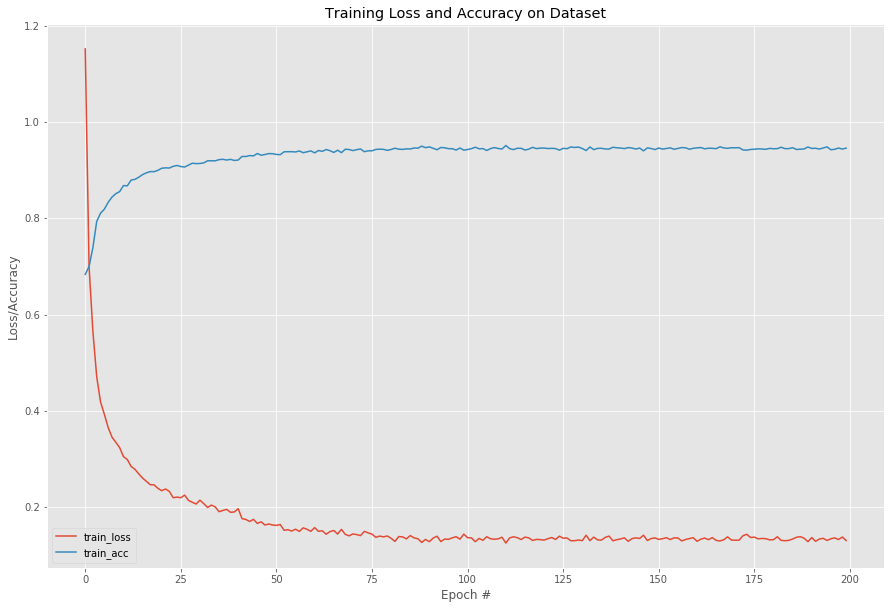

In [24]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure(figsize=(15, 10))
plt.plot(history.history["loss"], label="train_loss")
# plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(history.history["accuracy"], label="train_acc")
# plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("Unet64_batch_relu_dropout_noVal.png")
plt.show()

In [12]:
from helpers import *

# from cnn_model import cnn_model

# Instantiate the model
batch_normalization = True
activation = "LeakyReLU"
model = cnn_model(
    shape=(64, 64, 3), batch_normalization=batch_normalization, activation=activation
)

# Load the model
model.load("Unet64_batch_relu_dropout_noVal-111-0.951604.h5")

# Print a summary to make sure the correct model is used
model.model.summary()

# We add all test images to an array, used later for generating a submission
image_filenames = []
for i in range(1, 51):
    image_filename = "data/test_set_images/test_" + str(i) + "/test_" + str(i) + ".png"
    image_filenames.append(image_filename)

# Set-up submission filename
submission_filename = "Unet64_batch_relu_dropout_noVal-111-0.951604.csv"

# Generates the submission
generate_submission(model, submission_filename, *image_filenames)

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/tas

# TODO
1. Increase regulrization parameters
2. Increase dropout prob 

In [ ]:
# Load a set of images
root_dir = "data/training/"

# Select the directory for the images and load them
image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = len(files)

print("Loading " + str(n) + " images")
imgs = np.asarray([load_image(image_dir + files[i]) for i in range(n)])

# Select the directory for groundtruth images and load them
gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " groundtruth images")
gt_imgs = np.asarray([load_image(gt_dir + files[i]) for i in range(n)])

In [ ]:
image_size = 400

# We separate the images from the groundtruth images
img_patches = [img_crop(imgs[i], image_size, image_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], image_size, image_size) for i in range(n)]

# Linearize the list and labeling them X and Y
X = np.asarray(
    [
        img_patches[i][j]
        for i in range(len(img_patches))
        for j in range(len(img_patches[i]))
    ]
)
Y = np.asarray(
    [
        gt_patches[i][j]
        for i in range(len(gt_patches))
        for j in range(len(gt_patches[i]))
    ]
)

In [ ]:
def create_minibatch():

    # Fix the seed
    np.random.seed(1)

    # We define the window size of 72, batch size of 100 (empirically chosen)
    # and patch size should correspond to 16
    w_size = 72
    batch_size = 100
    patch_size = 16
    num_images = 100

    while True:
        # Generate one minibatch
        batch_image = np.empty((batch_size, w_size, w_size, 3))
        batch_label = np.empty((batch_size, 2))

        for i in range(batch_size):

            # Select a random index represnting an image
            random_index = np.random.choice(num_images)

            # Width of original image
            width = 400

            # Sample a random window from the image
            random_sample = np.random.randint(w_size // 2, width - w_size // 2, 2)

            # Create a sub image of size 72x72
            sampled_image = X[random_index][
                random_sample[0] - w_size // 2 : random_sample[0] + w_size // 2,
                random_sample[1] - w_size // 2 : random_sample[1] + w_size // 2,
            ]

            # Take its corresponding ground-truth image
            correspond_ground_truth = Y[random_index][
                random_sample[0] - patch_size // 2 : random_sample[0] + patch_size // 2,
                random_sample[1] - patch_size // 2 : random_sample[1] + patch_size // 2,
            ]

            # We set in the label depending on the threshold of 0.2
            # The label becomes either 0 or 1 by applying to_categorical with parameter 2
            label = to_categorical(
                (np.array([np.mean(correspond_ground_truth)]) > 0.2) * 1, 2
            )

            # The image augmentation is based on both flipping and rotating (randomly in steps of 45°)
            # Random vertical and horizontal flip
            if np.random.choice(2) == 1:
                sampled_image = np.flipud(sampled_image)

            if np.random.choice(2) == 1:
                sampled_image = np.fliplr(sampled_image)

            # Random rotation in steps of 45°
            rotations = [0, 45, 90, 135, 180, 225, 270, 315, 350]

            # We select a rotation degree randomly
            rotation_choice = np.random.choice(len(rotations))

            # Rotate it using the random value (uses the scipy library)
            sampled_image = scipy.ndimage.rotate(
                sampled_image,
                rotations[rotation_choice],
                order=1,
                reshape=False,
                mode="reflect",
            )

            # We put in the sub image and its corresponding label before yielding it
            batch_image[i] = sampled_image
            batch_label[i] = label

        # Yield the mini_batch to the model
        yield (batch_image, batch_label)

In [ ]:
class cnn_model:

    # Initialize the class
    def __init__(self, shape, batch_normalization, activation):
        self.shape = shape
        self.batch_normalization = batch_normalization
        self.activation = activation
        self.model = self.initialize_cnn_model(shape, batch_normalization, activation)

    def initialize_cnn_model(self, shape, batch_normalization, activation):
        #         print(activation)

        # INPUT
        # shape     - Size of the input images
        # OUTPUT
        # model    - Compiled CNN

        # Define hyperparamters
        KERNEL3 = (3, 3)
        KERNEL5 = (5, 5)

        # Define a model
        model = Sequential()

        # Add the layers
        # Selection of the model is described in the report
        # We use padding = 'same' to avoid issues with the matrix sizes
        model.add(Conv2D(64, KERNEL3, input_shape=shape, padding="same"))
        model.add(GaussianNoise(0.1))

        if batch_normalization:
            model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
            Activation(activation)
        )
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Dropout(0.2))

        model.add(Conv2D(128, KERNEL3, padding="same"))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
            Activation(activation)
        )
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Dropout(0.2))

        model.add(Conv2D(256, KERNEL3, padding="same"))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
            Activation(activation)
        )
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Dropout(0.2))

        model.add(Conv2D(256, KERNEL3, padding="same"))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
            Activation(activation)
        )
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Dropout(0.2))

        model.add(Conv2D(256, KERNEL3, padding="same"))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
            Activation(activation)
        )
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Dropout(0.2))

        model.add(Conv2D(256, KERNEL3, padding="same"))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
            Activation(activation)
        )
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Dropout(0.2))

        # Flatten it and use regularizers to avoid overfitting
        # The parameters have been chosen empirically
        model.add(Flatten())
        model.add(
            Dense(
                128, kernel_regularizer=l2(0.000001), activity_regularizer=l2(0.000001)
            )
        )
        model.add(LeakyReLU(alpha=0.1))
        model.add(Dropout(0.5))

        # Add output layer
        model.add(
            Dense(2, kernel_regularizer=l2(0.000001), activity_regularizer=l2(0.000001))
        )
        model.add(Activation("sigmoid"))

        # Compile the model using the binary crossentropy loss and the Adam optimizer for it
        # We used the accuracy as a metric, but F1 score is also a plausible choice
        model.compile(
            loss="binary_crossentropy",
            optimizer=Adam(lr=0.001, amsgrad=True),
            metrics=["accuracy", recall, f1],
        )

        # Print a summary of the model to see what has been generated
        model.summary()

        return model

    def train(self):

        # Early stopping callback after 10 steps
        early_stopping = EarlyStopping(
            monitor="f1", min_delta=0.5, patience=20, verbose=0, mode="max"
        )

        # Reduce learning rate on plateau after 4 steps
        lr_callback = ReduceLROnPlateau(
            monitor="f1", factor=0.5, patience=4, verbose=0, mode="max"
        )

        # Place the callbacks in a list to be used when training
        #         callbacks = [cb, early_stopping, lr_callback]
        save_best = ModelCheckpoint(
            "batch_relu_OLD_Ali_amsgrad_noise-{epoch:03d}-{f1:03f}.h5",
            save_best_only=True,
            monitor="f1",
            mode="max",
            verbose=1,
        )

        callbacks = [lr_callback, save_best]

        # Train the model using the previously defined functions and callbacks
        history = self.model.fit_generator(
            create_minibatch(),
            steps_per_epoch=STEPS_PER_EPOCH,
            epochs=EPOCHS,
            use_multiprocessing=False,
            workers=1,
            callbacks=callbacks,
            verbose=1,
        )

        return history

    def classify(self, X):
        # Subdivide the images into blocks with a stride and patch_size of 16
        img_patches = create_patches(X, 16, 16, padding=28)

        # Predict
        predictions = self.model.predict(img_patches)
        predictions = (predictions[:, 0] < predictions[:, 1]) * 1

        # Regroup patches into images
        return group_patches(predictions, X.shape[0])

    def load(self, filename):
        # Load the model (used for submission)
        dependencies = {
            "recall": recall,
            "f1": f1,
        }
        self.model = load_model(filename, custom_objects=dependencies)

    def save(self, filename):
        # Save the model (used to then load to submit)
        self.model.save(filename)

In [ ]:
# Instantiate the model with the size 72x72, the window size of the images to be fed
EPOCHS = 120
STEPS_PER_EPOCH = 150
batch_normalization = True
activation = "relu"
model = cnn_model(
    shape=(72, 72, 3), batch_normalization=batch_normalization, activation=activation
)
# Train the model with batch
history = model.train()
model.save("batch_relu_OLD_Ali_amsgrad_noise.h5")

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure(figsize=(15, 10))
plt.plot(history.history["loss"], label="train_loss")
# plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(history.history["accuracy"], label="train_acc")
# plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("batch_relu_OLD_Ali_amsgrad_noise.png")
plt.show()

In [ ]:
from helpers import *

# from cnn_model import cnn_model

# Instantiate the model
batch_normalization = True
activation = "relu"
model = cnn_model(
    shape=(72, 72, 3), batch_normalization=batch_normalization, activation=activation
)

# Load the model
model.load("batch_relu_OLD_Ali_amsgrad_noise-092-0.952039.h5")

# Print a summary to make sure the correct model is used
model.model.summary()

# We add all test images to an array, used later for generating a submission
image_filenames = []
for i in range(1, 51):
    image_filename = "data/test_set_images/test_" + str(i) + "/test_" + str(i) + ".png"
    image_filenames.append(image_filename)

# Set-up submission filename
submission_filename = "batch_relu_OLD_Ali_amsgrad_noise-092-0.952039.csv"

# Generates the submission
generate_submission(model, submission_filename, *image_filenames)

In [ ]:
# Instantiate the model with the size 72x72, the window size of the images to be fed
# We define the number of epochs and steps per epochs
EPOCHS = 160
STEPS_PER_EPOCH = 150
batch_normalization = True
activation = "LeakyReLU"
model = cnn_model(
    shape=(72, 72, 3), batch_normalization=batch_normalization, activation=activation
)
# Train the model
history = model.train()
# model.save("no_batch_LeakyRelu_validation_1.h5")

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure(figsize=(15, 10))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("batch_LeakyReLU_validation_160_dropout-0.2.png")
plt.show()


In [ ]:
from helpers import *

# from cnn_model import cnn_model

# Instantiate the model
batch_normalization = True
activation = "LeakyReLU"
model = cnn_model(
    shape=(72, 72, 3), batch_normalization=batch_normalization, activation=activation
)

# Load the model
model.load(
    "saved_models/batch_LeakyReLU_validation_160_dropout-0.2-070-0.948567-0.928000.h5"
)

# Print a summary to make sure the correct model is used
model.model.summary()

# We add all test images to an array, used later for generating a submission
image_filenames = []
for i in range(1, 51):
    image_filename = "data/test_set_images/test_" + str(i) + "/test_" + str(i) + ".png"
    image_filenames.append(image_filename)

# Set-up submission filename
submission_filename = "to_submit_csv/batch_LeakyReLU_validation_160_dropout-0.2-070-0.948567-0.928000.csv"

# Generates the submission
generate_submission(model, submission_filename, *image_filenames)

In [ ]:
# # history.history["loss"]
# print(history.history.keys())

In [ ]:
# plt.plot(history.history["accuracy"])
# plt.plot(history.history["val_accuracy"])
# plt.title("model accuracy")
# plt.ylabel("accuracy")
# plt.xlabel("epoch")
# plt.legend(["train", "val"], loc="upper left")
# plt.show()

In [ ]:
# # plot the training loss and accuracy
# N = EPOCHS
# print(N)
# plt.style.use("ggplot")
# plt.figure()
# plt.plot(history.history["loss"], label="train_loss")
# plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
# plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
# plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
# plt.title("Training Loss and Accuracy on Dataset")
# plt.xlabel("Epoch #")
# plt.ylabel("Loss/Accuracy")
# plt.legend(loc="lower left")
# plt.show()
# plt.savefig("model1.png")

In [ ]:
# # Instantiate the model with the size 72x72, the window size of the images to be fed
# batch_normalization = False
# EPOCHS = 200

# activation = "relu"
# model = cnn_model(
#     shape=(72, 72, 3), batch_normalization=batch_normalization, activation=activation
# )
# # Train the model with batch
# model.train()
# model.save("no_batch_relu_validation.h5")

In [ ]:
# # Instantiate the model with the size 72x72, the window size of the images to be fed
# batch_normalization = True
# EPOCHS = 200

# activation = "LeakyReLU"
# model = cnn_model(
#     shape=(72, 72, 3), batch_normalization=batch_normalization, activation=activation
# )
# # Train the model with batch
# model.train()
# model.save("batch_LeakyReLU_validation.h5")

In [ ]:
# Instantiate the model with the size 72x72, the window size of the images to be fed
batch_normalization = True
EPOCHS = 200
STEPS_PER_EPOCH = 150
activation = "relu"
model = cnn_model(
    shape=(72, 72, 3), batch_normalization=batch_normalization, activation=activation
)
# Train the model with batch
history = model.train()
# model.save("batch_relu_validation_200.h5")

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure(figsize=(15, 10))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("batch_relu_validation_200.png")
plt.show()


In [ ]:
from helpers import *

# from cnn_model import cnn_model

# Instantiate the model
batch_normalization = True
activation = "relu"
model = cnn_model(
    shape=(72, 72, 3), batch_normalization=batch_normalization, activation=activation
)

# Load the model
model.load("batch_relu_validation_200-145-0.951267-0.930033.h5")

# Print a summary to make sure the correct model is used
model.model.summary()

# We add all test images to an array, used later for generating a submission
image_filenames = []
for i in range(1, 51):
    image_filename = "data/test_set_images/test_" + str(i) + "/test_" + str(i) + ".png"
    image_filenames.append(image_filename)

# Set-up submission filename
submission_filename = "batch_relu_validation_200-145-0.951267-0.930033.csv"

# Generates the submission
generate_submission(model, submission_filename, *image_filenames)

In [ ]:
# Instantiate the model with the size 72x72, the window size of the images to be fed
batch_normalization = True
EPOCHS = 160
STEPS_PER_EPOCH = 150
activation = "LeakyReLU"
model = cnn_model(
    shape=(72, 72, 3), batch_normalization=batch_normalization, activation=activation
)
# Train the model with batch
history = model.train()
# model.save("batch_relu_validation_200.h5")

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure(figsize=(15, 10))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("batch_LeakyReLU_validation_160.png")
plt.show()


In [ ]:
from helpers import *

# from cnn_model import cnn_model

# Instantiate the model
batch_normalization = True
activation = "LeakyReLU"
model = cnn_model(
    shape=(72, 72, 3), batch_normalization=batch_normalization, activation=activation
)

# Load the model
model.load("batch_relu_validation_200-074-0.946167-0.927667.h5")

# Print a summary to make sure the correct model is used
model.model.summary()

# We add all test images to an array, used later for generating a submission
image_filenames = []
for i in range(1, 51):
    image_filename = "data/test_set_images/test_" + str(i) + "/test_" + str(i) + ".png"
    image_filenames.append(image_filename)

# Set-up submission filename
submission_filename = "batch_relu_validation_200-074-0.946167-0.927667.csv"

# Generates the submission
generate_submission(model, submission_filename, *image_filenames)

# NEW BATCH ERICK V7

In [ ]:
import scipy as scipy


def pad_matrix(mat, h_pad, w_pad, val=0):
    h_pad = int(h_pad)
    w_pad = int(w_pad)
    if len(mat.shape) == 3:
        padded_mat = np.pad(
            mat,
            ((h_pad, h_pad), (w_pad, w_pad), (0, 0)),
            mode="constant",
            constant_values=((val, val), (val, val), (0, 0)),
        )
    elif len(mat.shape) == 2:
        padded_mat = np.pad(
            mat,
            ((h_pad, h_pad), (w_pad, w_pad)),
            mode="constant",
            constant_values=((val, val), (val, val)),
        )
    else:
        raise ValueError("This method can only handle 2d or 3d arrays")
    return padded_mat


def imag_rotation(X, Y, number_rotations=8):

    w = X.shape[1]
    w_2 = w // 2  # half of the width
    padding = 82
    Xrs = X
    Yrs = Y
    Xrs = np.expand_dims(Xrs, 0)
    Yrs = np.expand_dims(Yrs, 0)
    thetas = np.random.randint(0, high=360, size=number_rotations)
    for theta in thetas:
        Xr = pad_matrix(
            X, padding, padding
        )  # Selected for the specific case of images of (400,400)
        Yr = pad_matrix(
            Y, padding, padding
        )  # Selected for the specific case of images of (400,400)
        Xr = scipy.ndimage.rotate(Xr, theta, reshape=False)
        Yr = scipy.ndimage.rotate(Yr, theta, reshape=False)
        theta = theta * np.pi / 180
        a = int(
            w_2 / (np.sqrt(2) * np.cos(np.pi / 4 - np.mod(theta, np.pi / 2)))
        )  # width and height of the biggest square inside the rotated square
        w_p = w_2 + padding
        Xr = Xr[w_p - a : w_p + a, w_p - a : w_p + a, :]
        Yr = Yr[w_p - a : w_p + a, w_p - a : w_p + a]

        Xr = cv2.resize(Xr, dsize=(w_2 * 2, w_2 * 2), interpolation=cv2.INTER_CUBIC)
        Yr = cv2.resize(Yr, dsize=(w_2 * 2, w_2 * 2), interpolation=cv2.INTER_CUBIC)

        if np.random.choice(2) == 1:
            Xr = np.flipud(Xr)
            Yr = np.flipud(Yr)

        if np.random.choice(2) == 1:
            Xr = np.fliplr(Xr)
            Yr = np.fliplr(Yr)

        Xr = np.expand_dims(Xr, 0)
        Yr = np.expand_dims(Yr, 0)
        Xrs = np.append(Xrs, Xr, axis=0)
        Yrs = np.append(Yrs, Yr, axis=0)

    return Xrs, Yrs


def imag_rotation_aug(Xr, Yr, number_rotations=8):

    Xrs, Yrs = imag_rotation(Xr[0], Yr[0])
    for i in range(1, len(Xr)):
        Xrr, Yrr = imag_rotation(Xr[i], Yr[i])
        Xrs = np.append(Xrs, Xrr, axis=0)
        Yrs = np.append(Yrs, Yrr, axis=0)

    Xrs_shuf = []
    Yrs_shuf = []
    index_shuf = list(range(len(Xrs)))
    np.random.shuffle(index_shuf)
    for i in index_shuf:
        Xrs_shuf.append(Xrs[i])
        Yrs_shuf.append(Yrs[i])

    return Xrs_shuf, Yrs_shuf

In [ ]:
# Load a set of images
root_dir = "data/"

# Select the directory for the images and load them
image_dir_train = root_dir + "training/images/"
files = os.listdir(image_dir_train)
n_train = len(files)

print("Loading " + str(n_train) + " images")
imgs_train = np.asarray(
    [load_image(image_dir_train + files[i]) for i in range(n_train)]
)

# Select the directory for groundtruth images and load them
gt_dir_train = root_dir + "training/groundtruth/"
print("Loading " + str(n_train) + " groundtruth images")
gt_imgs_train = np.asarray(
    [load_image(gt_dir_train + files[i]) for i in range(n_train)]
)

In [ ]:
# Select the directory for the images and load them
image_dir_val = root_dir + "validating/images/"
files = os.listdir(image_dir_val)
n_val = len(files)

print("Loading " + str(n_val) + " images")
imgs_val = np.asarray([load_image(image_dir_val + files[i]) for i in range(n_val)])

# Select the directory for groundtruth images and load them
gt_dir_val = root_dir + "validating/groundtruth/"
print("Loading " + str(n_val) + " groundtruth images")
gt_imgs_val = np.asarray([load_image(gt_dir_val + files[i]) for i in range(n_val)])

In [ ]:
X_train, Y_train = imag_rotation_aug(imgs_train, gt_imgs_train)

In [ ]:
X_val, Y_val = imag_rotation_aug(imgs_val, gt_imgs_val)

In [ ]:
def create_minibatch(X, Y, n):

    # Fix the seed
    np.random.seed(1)

    # We define the window size of 72, batch size of 100 (empirically chosen)
    # and patch size should correspond to 16
    w_size = 72
    batch_size = 80
    patch_size = 72
    num_images = n

    while True:
        # Generate one minibatch
        batch_image = np.empty((batch_size, w_size, w_size, 3))
        batch_label = np.empty((batch_size, 2))

        for i in range(batch_size):

            # Select a random index representing an image
            random_index = np.random.choice(num_images)

            # Width of original image
            width = 400

            # Sample a random window from the image
            random_sample = np.random.randint(w_size // 2, width - w_size // 2, 2)

            # Create a sub image of size 72x72
            sampled_image = X[random_index][
                random_sample[0] - w_size // 2 : random_sample[0] + w_size // 2,
                random_sample[1] - w_size // 2 : random_sample[1] + w_size // 2,
            ]

            # Take its corresponding ground-truth image
            correspond_ground_truth = Y[random_index][
                random_sample[0] - patch_size // 2 : random_sample[0] + patch_size // 2,
                random_sample[1] - patch_size // 2 : random_sample[1] + patch_size // 2,
            ]

            # We set in the label depending on the threshold of 0.2
            # The label becomes either 0 or 1 by applying to_categorical with parameter 2
            label = to_categorical(
                (np.array([np.mean(correspond_ground_truth)]) > 0.2) * 1, 2
            )

            # We put in the sub image and its corresponding label before yielding it
            batch_image[i] = sampled_image
            batch_label[i] = label

        # Yield the mini_batch to the model
        yield (batch_image, batch_label)

In [ ]:
class cnn_model:

    # Initialize the class
    def __init__(self, shape, batch_normalization, activation):
        self.shape = shape
        self.batch_normalization = batch_normalization
        self.activation = activation
        self.model = self.initialize_cnn_model(shape, batch_normalization, activation)

    def initialize_cnn_model(self, shape, batch_normalization, activation):
        #         print(activation)

        # INPUT
        # shape     - Size of the input images
        # OUTPUT
        # model    - Compiled CNN

        # Define hyperparamters
        KERNEL3 = (3, 3)
        KERNEL5 = (5, 5)

        # Define a model
        model = Sequential()

        # Add the layers
        # Selection of the model is described in the report
        # We use padding = 'same' to avoid issues with the matrix sizes
        model.add(Conv2D(64, KERNEL5, input_shape=shape, padding="same"))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
            Activation(activation)
        )
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Dropout(0.2))

        model.add(Conv2D(128, KERNEL3, padding="same"))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
            Activation(activation)
        )
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Dropout(0.2))

        model.add(Conv2D(256, KERNEL3, padding="same"))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
            Activation(activation)
        )
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Dropout(0.2))

        model.add(Conv2D(256, KERNEL3, padding="same"))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
            Activation(activation)
        )
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Dropout(0.2))

        model.add(Conv2D(256, KERNEL3, padding="same"))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
            Activation(activation)
        )
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Dropout(0.2))

        model.add(Conv2D(256, KERNEL3, padding="same"))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
            Activation(activation)
        )
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Dropout(0.2))

        # Flatten it and use regularizers to avoid overfitting
        # The parameters have been chosen empirically
        model.add(Flatten())
        model.add(
            Dense(128, kernel_regularizer=l2(0.0001), activity_regularizer=l2(0.0001))
        )
        #         if batch_normalization:
        #             model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
            Activation(activation)
        )
        model.add(Dropout(0.5))

        # Add output layer
        model.add(
            Dense(2, kernel_regularizer=l2(0.0001), activity_regularizer=l2(0.0001))
        )
        model.add(Activation("sigmoid"))

        # Compile the model using the binary crossentropy loss and the Adam optimizer for it
        # We used the accuracy as a metric, but F1 score is also a plausible choice
        model.compile(
            loss="binary_crossentropy",
            optimizer=Adam(lr=0.001),
            metrics=["accuracy", recall, f1],
        )

        # Print a summary of the model to see what has been generated
        model.summary()

        return model

    def train(self):

        # Early stopping callback after 10 steps
        early_stopping = EarlyStopping(
            monitor="val_loss",
            min_delta=0,
            patience=15,
            verbose=1,
            mode="auto",
            restore_best_weights=True,
        )

        # Reduce learning rate on plateau after 4 steps
        lr_callback = ReduceLROnPlateau(
            monitor="loss", factor=0.5, patience=4, verbose=1, mode="auto"
        )
        save_best = ModelCheckpoint(
            "batch_LeakyReLU_validation_160_dropout-0.2_erickAugv7-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5",
            save_best_only=True,
            monitor="val_loss",
            mode="auto",
            verbose=1,
        )

        # Place the callbacks in a list to be used when training
        #         callbacks = [cb, early_stopping, lr_callback]
        callbacks = [save_best, lr_callback]

        # Train the model using the previously defined functions and callbacks
        history = self.model.fit_generator(
            create_minibatch(X_train, Y_train, n_train * 9),
            steps_per_epoch=STEPS_PER_EPOCH,
            epochs=EPOCHS,
            use_multiprocessing=False,
            workers=1,
            callbacks=callbacks,
            verbose=1,
            validation_data=create_minibatch(X_val, Y_val, n_val * 9),
            validation_steps=STEPS_PER_EPOCH,
        )
        #         to_plot = self.model.fit_generator(
        #             create_minibatch(X_train, Y_train, n_train),
        #             steps_per_epoch=100,
        #             epochs=EPOCHS,
        #             use_multiprocessing=False,
        #             workers=1,
        #             callbacks=callbacks,
        #             verbose=1,
        #             validation_data=create_minibatch(X_val, Y_val, n_val),
        #             validation_steps=100,
        #         )
        return history

    def classify(self, X):
        # Subdivide the images into blocks with a stride and patch_size of 16
        img_patches = create_patches(X, 16, 16, padding=28)

        # Predict
        predictions = self.model.predict(img_patches)
        predictions = (predictions[:, 0] < predictions[:, 1]) * 1

        # Regroup patches into images
        return group_patches(predictions, X.shape[0])

    def load(self, filename):
        # Load the model (used for submission)
        dependencies = {
            "recall": recall,
            "f1": f1,
        }
        self.model = load_model(filename, custom_objects=dependencies)


#     def save(self, filename):
#         # Save the model (used to then load to submit)
#         self.model.save(filename)

In [ ]:
# Instantiate the model with the size 72x72, the window size of the images to be fed
batch_normalization = True
EPOCHS = 200
# EPOCHS = 2
STEPS_PER_EPOCH = 150
activation = "LeakyReLU"
model = cnn_model(
    shape=(72, 72, 3), batch_normalization=batch_normalization, activation=activation
)
# Train the model with batch
history = model.train()
# model.save("batch_relu_validation_200.h5")

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure(figsize=(15, 10))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("batch_LeakyReLU_validation_erickv7.png")
plt.show()

In [ ]:
from helpers import *

# from cnn_model import cnn_model

# Instantiate the model
batch_normalization = True
activation = "LeakyReLU"
model = cnn_model(
    shape=(72, 72, 3), batch_normalization=batch_normalization, activation=activation
)

# Load the model
model.load(
    "batch_LeakyReLU_validation_160_dropout-0.2_erickAugv7-099-0.956417-0.907208.h5"
)

# Print a summary to make sure the correct model is used
model.model.summary()

# We add all test images to an array, used later for generating a submission
image_filenames = []
for i in range(1, 51):
    image_filename = "data/test_set_images/test_" + str(i) + "/test_" + str(i) + ".png"
    image_filenames.append(image_filename)

# Set-up submission filename
submission_filename = (
    "batch_LeakyReLU_validation_160_dropout-0.2_erickAugv7-099-0.956417-0.907208.csv"
)

# Generates the submission
generate_submission(model, submission_filename, *image_filenames)

In [ ]:
class cnn_model:

    # Initialize the class
    def __init__(self, shape, batch_normalization, activation):
        self.shape = shape
        self.batch_normalization = batch_normalization
        self.activation = activation
        self.model = self.initialize_cnn_model(shape, batch_normalization, activation)

    def initialize_cnn_model(self, shape, batch_normalization, activation):
        #         print(activation)

        # INPUT
        # shape     - Size of the input images
        # OUTPUT
        # model    - Compiled CNN

        # Define hyperparamters
        KERNEL3 = (3, 3)
        KERNEL5 = (5, 5)

        # Define a model
        model = Sequential()

        # Add the layers
        # Selection of the model is described in the report
        # We use padding = 'same' to avoid issues with the matrix sizes
        model.add(Conv2D(64, KERNEL5, input_shape=shape, padding="same"))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
            Activation(activation)
        )
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Dropout(0.5))

        model.add(Conv2D(128, KERNEL3, padding="same"))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
            Activation(activation)
        )
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Dropout(0.5))

        model.add(Conv2D(256, KERNEL3, padding="same"))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
            Activation(activation)
        )
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Dropout(0.5))

        model.add(Conv2D(256, KERNEL3, padding="same"))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
            Activation(activation)
        )
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Dropout(0.5))

        model.add(Conv2D(256, KERNEL3, padding="same"))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
            Activation(activation)
        )
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Dropout(0.5))

        model.add(Conv2D(256, KERNEL3, padding="same"))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
            Activation(activation)
        )
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Dropout(0.5))

        # Flatten it and use regularizers to avoid overfitting
        # The parameters have been chosen empirically
        model.add(Flatten())
        model.add(
            Dense(128, kernel_regularizer=l2(0.001), activity_regularizer=l2(0.001))
        )
        #         if batch_normalization:
        #             model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
            Activation(activation)
        )
        model.add(Dropout(0.5))

        # Add output layer
        model.add(
            Dense(2, kernel_regularizer=l2(0.001), activity_regularizer=l2(0.001))
        )
        model.add(Activation("sigmoid"))

        # Compile the model using the binary crossentropy loss and the Adam optimizer for it
        # We used the accuracy as a metric, but F1 score is also a plausible choice
        model.compile(
            loss="binary_crossentropy",
            optimizer=Adam(lr=0.0005, amsgrad=True),
            metrics=["accuracy", recall, f1],
        )

        # Print a summary of the model to see what has been generated
        model.summary()

        return model

    def train(self):

        # Early stopping callback after 10 steps
        early_stopping = EarlyStopping(
            monitor="val_loss",
            min_delta=0,
            patience=15,
            verbose=1,
            mode="auto",
            restore_best_weights=True,
        )

        # Reduce learning rate on plateau after 4 steps
        lr_callback = ReduceLROnPlateau(
            monitor="loss", factor=0.5, patience=4, verbose=1, mode="auto"
        )
        save_best = ModelCheckpoint(
            "batch_LeakyReLU_validation_200_dropout-0.5_erickAugv7-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5",
            save_best_only=True,
            monitor="val_f1",
            mode="max",
            verbose=1,
        )

        # Place the callbacks in a list to be used when training
        #         callbacks = [cb, early_stopping, lr_callback]
        callbacks = [save_best, lr_callback]

        # Train the model using the previously defined functions and callbacks
        history = self.model.fit_generator(
            create_minibatch(X_train, Y_train, n_train * 9),
            steps_per_epoch=STEPS_PER_EPOCH,
            epochs=EPOCHS,
            use_multiprocessing=False,
            workers=1,
            callbacks=callbacks,
            verbose=1,
            validation_data=create_minibatch(X_val, Y_val, n_val * 9),
            validation_steps=STEPS_PER_EPOCH,
        )
        #         to_plot = self.model.fit_generator(
        #             create_minibatch(X_train, Y_train, n_train),
        #             steps_per_epoch=100,
        #             epochs=EPOCHS,
        #             use_multiprocessing=False,
        #             workers=1,
        #             callbacks=callbacks,
        #             verbose=1,
        #             validation_data=create_minibatch(X_val, Y_val, n_val),
        #             validation_steps=100,
        #         )
        return history

    def classify(self, X):
        # Subdivide the images into blocks with a stride and patch_size of 16
        img_patches = create_patches(X, 16, 16, padding=28)

        # Predict
        predictions = self.model.predict(img_patches)
        predictions = (predictions[:, 0] < predictions[:, 1]) * 1

        # Regroup patches into images
        return group_patches(predictions, X.shape[0])

    def load(self, filename):
        # Load the model (used for submission)
        dependencies = {
            "recall": recall,
            "f1": f1,
        }
        self.model = load_model(filename, custom_objects=dependencies)


#     def save(self, filename):
#         # Save the model (used to then load to submit)
#         self.model.save(filename)

In [ ]:
# Instantiate the model with the size 72x72, the window size of the images to be fed
batch_normalization = True
EPOCHS = 150
# EPOCHS = 2
STEPS_PER_EPOCH = 150
activation = "LeakyReLU"
model = cnn_model(
    shape=(72, 72, 3), batch_normalization=batch_normalization, activation=activation
)
# Train the model with batch
history = model.train()
# model.save("batch_relu_validation_200.h5")

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure(figsize=(15, 10))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(history.history["f1"], label="train_f1")
plt.plot(history.history["val_f1"], label="val_f1")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("batch_LeakyReLU_validation_erickv7_dropout0.5_adagram.png")
plt.show()

In [ ]:
from helpers import *

# from cnn_model import cnn_model

# Instantiate the model
batch_normalization = True
activation = "LeakyReLU"
model = cnn_model(
    shape=(72, 72, 3), batch_normalization=batch_normalization, activation=activation
)

# Load the model
model.load(
    "batch_LeakyReLU_validation_200_dropout-0.5_erickAugv7-074-0.912500-0.858625.h5"
)

# Print a summary to make sure the correct model is used
model.model.summary()

# We add all test images to an array, used later for generating a submission
image_filenames = []
for i in range(1, 51):
    image_filename = "data/test_set_images/test_" + str(i) + "/test_" + str(i) + ".png"
    image_filenames.append(image_filename)

# Set-up submission filename
submission_filename = (
    "batch_LeakyReLU_validation_200_dropout-0.5_erickAugv7-074-0.912500-0.858625.csv"
)

# Generates the submission
generate_submission(model, submission_filename, *image_filenames)